# Equal-width discretization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
# load the California House price data from Scikit-learn
X, y = fetch_california_housing(return_X_y=True, as_frame=True)

# display top 5 rows
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [3]:
# let's separate the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=0,
)

X_train.shape, X_test.shape

((14448, 8), (6192, 8))

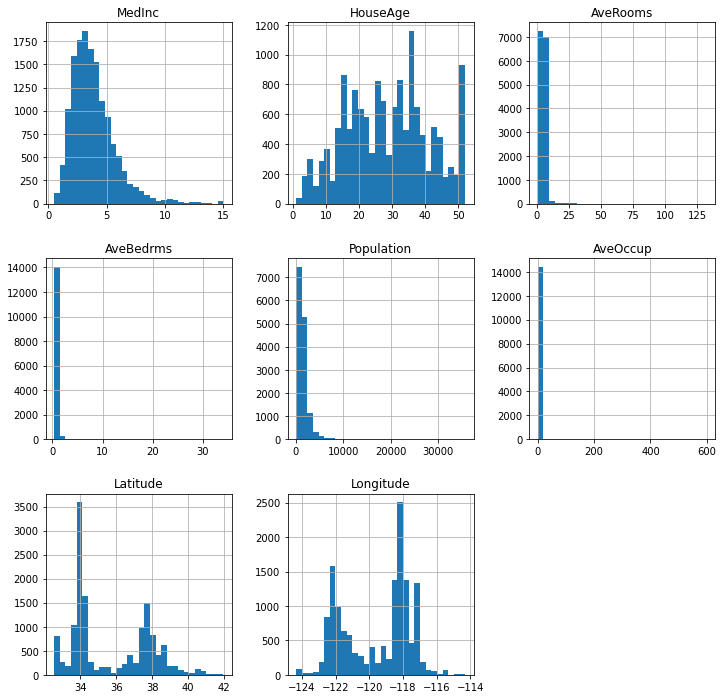

In [4]:
# Plot histograms to inspect variable distributions

X_train.hist(bins=30, figsize=(12, 12))
plt.show()

## Equal-width discretization with pandas

First we need to determine the interval edges or limits.

In [5]:
# Let's capture the minimum and maximum values

min_value = int(X_train["HouseAge"].min())
max_value = int(X_train["HouseAge"].max())

min_value, max_value

(1, 52)

In [6]:
# We want to sort the variable into 10 bins.
# let's determine the interval width

width = int((max_value - min_value) / 10)

width

5

In [7]:
# let's generate the interval limits

interval_limits = [i for i in range(min_value, max_value, width)]

interval_limits

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51]

In [8]:
# let's expand the limits of the first and 
# last interval to accommodate smaller or greater values

# pd.cut will automatically extend the intervals by 0.1 in
# each direction. This may or may not be enough depending on
# the variable scale and the nature of the data

interval_limits[0] = -np.inf
interval_limits[-1] = np.inf

interval_limits

[-inf, 6, 11, 16, 21, 26, 31, 36, 41, 46, inf]

In [9]:
# We'll make a copy of the train and test set

train_t = X_train.copy()
test_t = X_test.copy()

In [10]:
# discretise the variable in train set

train_t["HouseAge_disc"] = pd.cut(
    x=X_train["HouseAge"], bins=interval_limits, include_lowest=True)

print(train_t[["HouseAge", "HouseAge_disc"]].head(10))

       HouseAge HouseAge_disc
1989       52.0   (46.0, inf]
256        43.0  (41.0, 46.0]
7887       17.0  (16.0, 21.0]
4581       17.0  (16.0, 21.0]
1993       50.0   (46.0, inf]
10326      11.0   (6.0, 11.0]
10339      14.0  (11.0, 16.0]
12992      17.0  (16.0, 21.0]
10458       6.0   (-inf, 6.0]
1700       10.0   (6.0, 11.0]


In [11]:
# let's discretise the variables in the test set

test_t["HouseAge_disc"] = pd.cut(
    x=X_test["HouseAge"], bins=interval_limits, include_lowest=True)

test_t[["HouseAge", "HouseAge_disc"]].head()

,HouseAge,HouseAge_disc
14740,22.0,"(21.0, 26.0]"
10101,32.0,"(31.0, 36.0]"
20566,29.0,"(26.0, 31.0]"
2670,37.0,"(36.0, 41.0]"
15709,25.0,"(21.0, 26.0]"


In [12]:
plt.rcParams["figure.dpi"] = 450

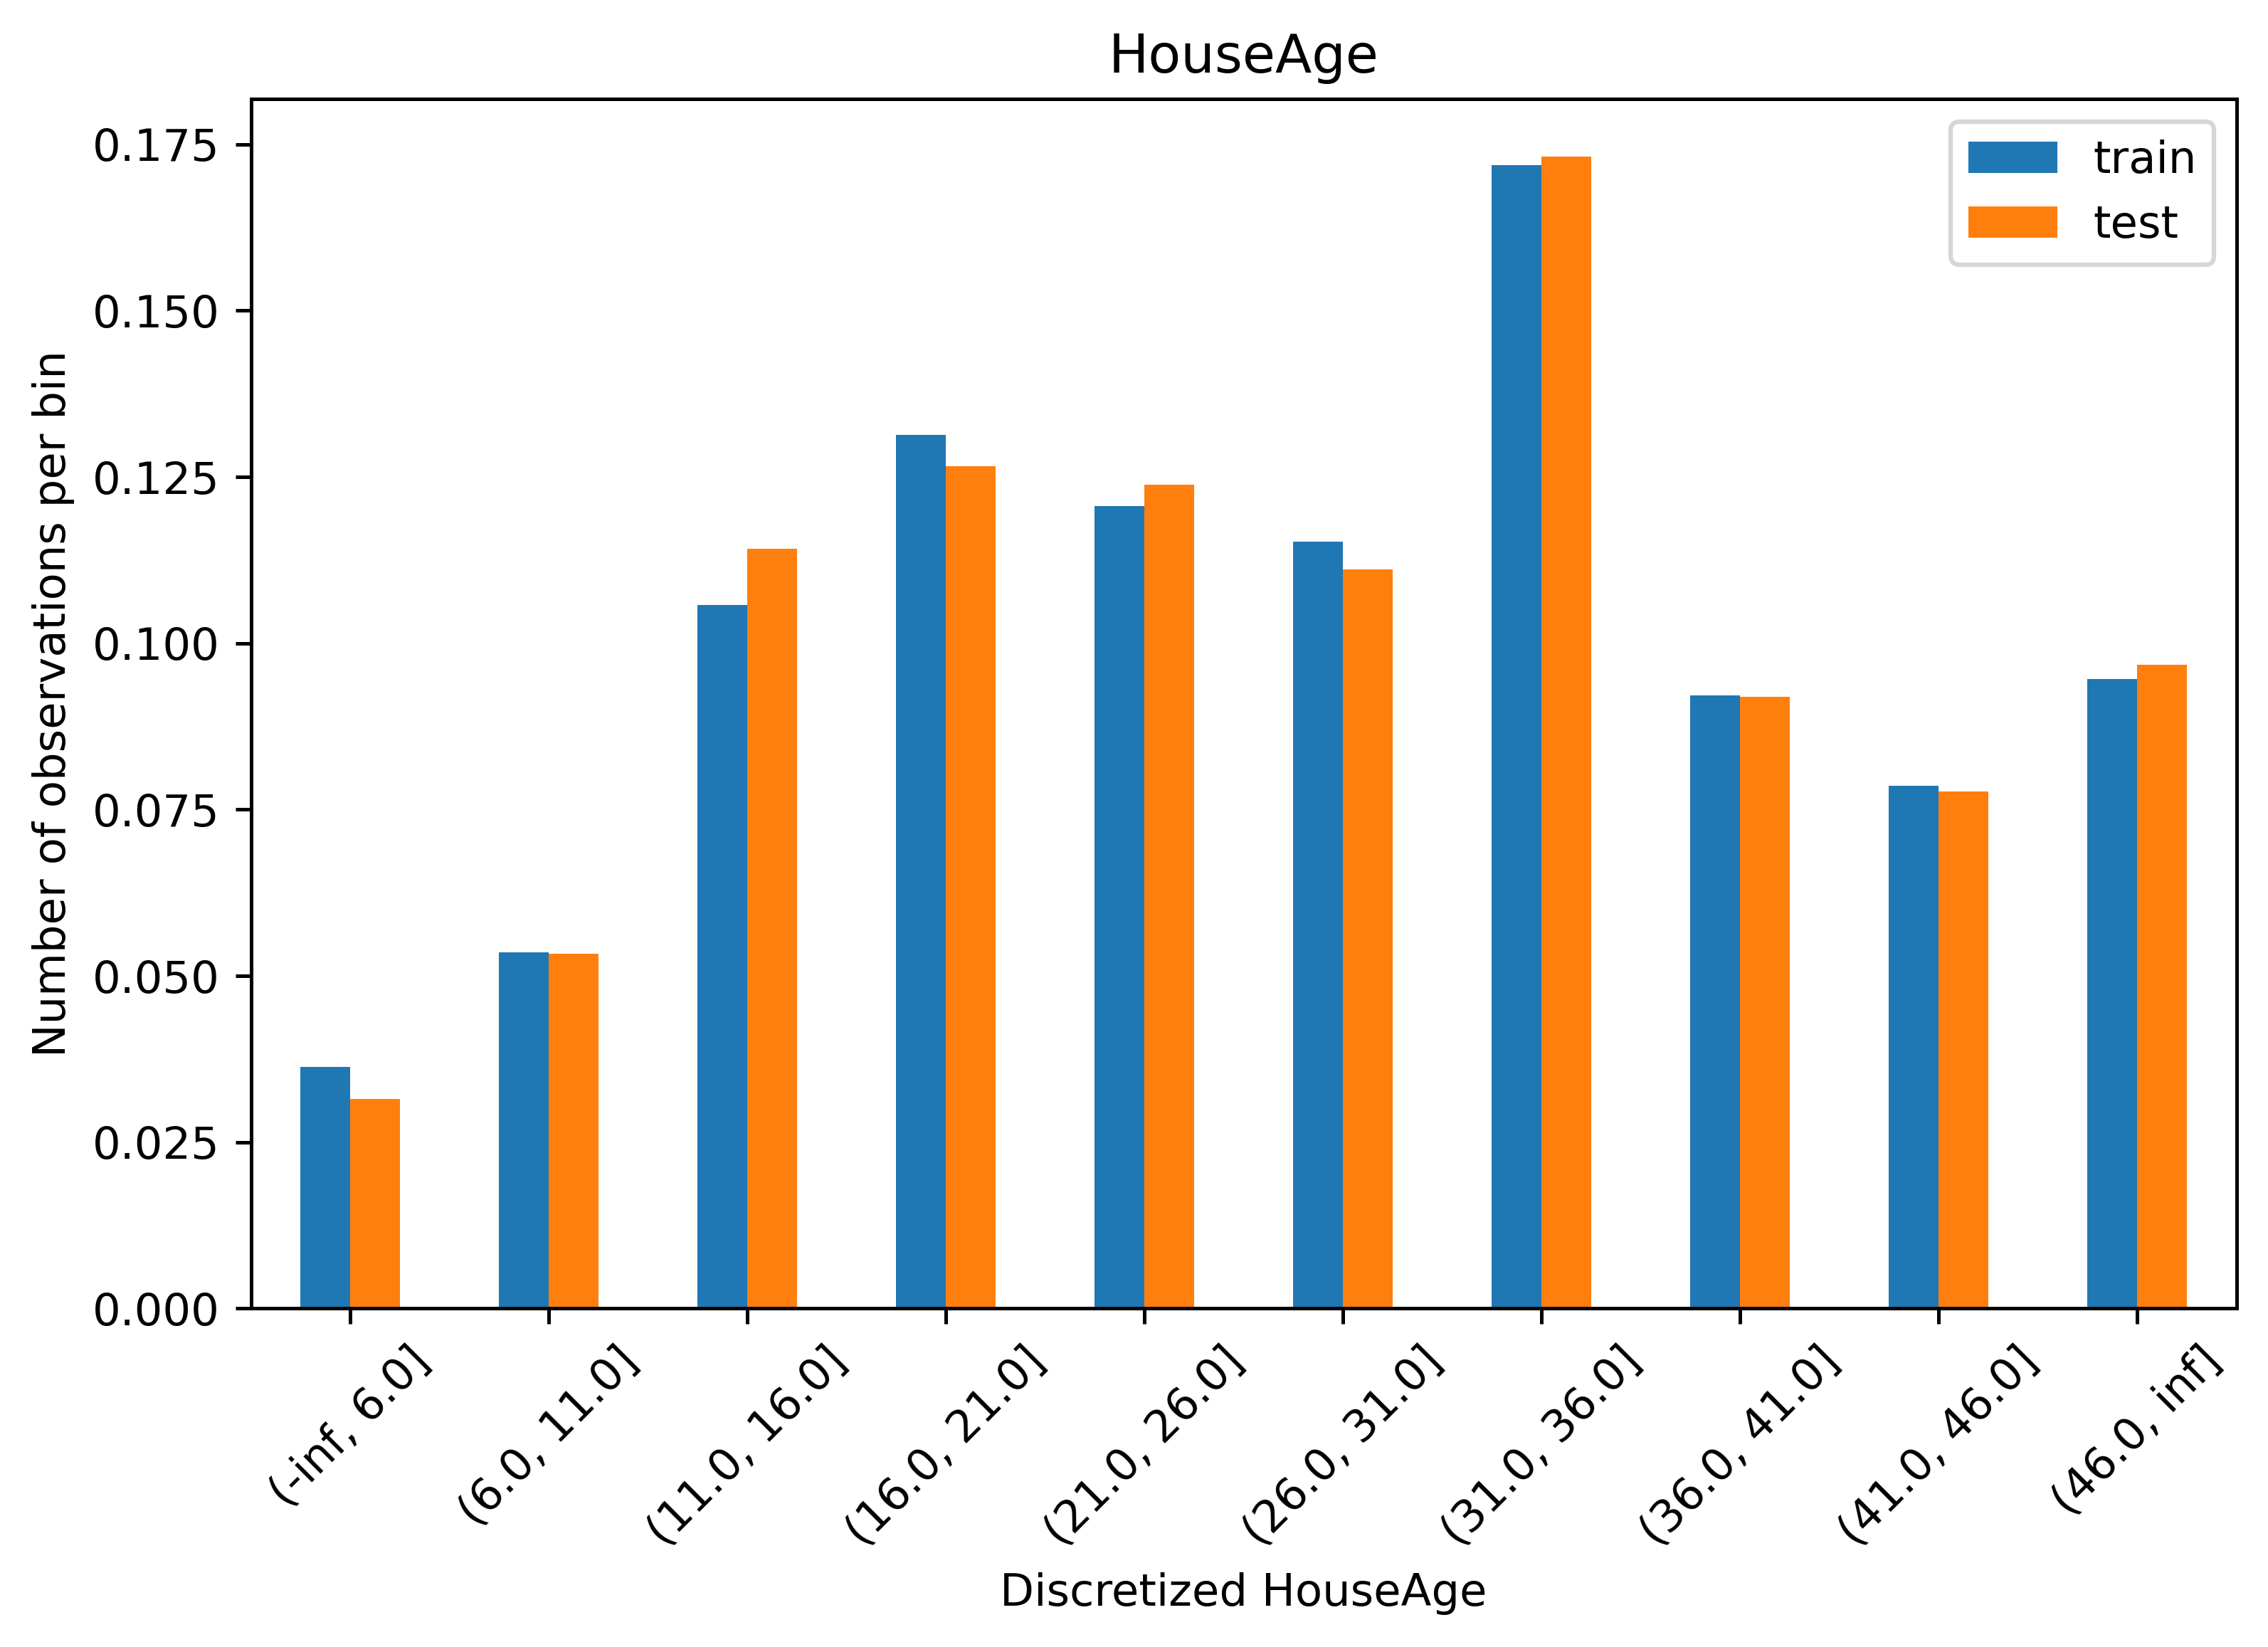

In [13]:
# Let's make bar plots with the number of observations
# per interval

# determine proportion of observations per bin
t1 = train_t["HouseAge_disc"].value_counts(normalize=True, sort=False)
t2 = test_t["HouseAge_disc"].value_counts(normalize=True, sort=False)

# concatenate proportions
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ["train", "test"]

# plot
tmp.plot.bar(figsize=(8, 5))
plt.xticks(rotation=45)
plt.ylabel("Number of observations per bin")
plt.xlabel('Discretized HouseAge')
plt.title("HouseAge")
plt.show()

## Equal-width discretization with Feature-engine

In [14]:
from feature_engine.discretisation import EqualWidthDiscretiser

In [15]:
# the variables to discretise

variables = ["MedInc", "HouseAge", "AveRooms"]

In [16]:
# With Feature-engine we can discretize subsets of variables

disc = EqualWidthDiscretiser(
    bins=8,
    variables=variables,
    return_boundaries=False,
)

disc.fit(X_train)

EqualWidthDiscretiser(bins=8, variables=['MedInc', 'HouseAge', 'AveRooms'])

In [17]:
# the limits of the intervals are stored in the binner_dict_

disc.binner_dict_

{'MedInc': [-inf,
  2.312425,
  4.12495,
  5.937475,
  7.75,
  9.562525,
  11.37505,
  13.187574999999999,
  inf],
 'HouseAge': [-inf, 7.375, 13.75, 20.125, 26.5, 32.875, 39.25, 45.625, inf],
 'AveRooms': [-inf,
  17.307051282051283,
  33.76794871794872,
  50.228846153846156,
  66.68974358974359,
  83.15064102564102,
  99.61153846153846,
  116.0724358974359,
  inf]}

In [18]:
# transform train and test sets

train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [19]:
# The original variable values are now
# replaced by the intervals:

test_t.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
14740,2,3,0,1.075472,1551.0,4.180593,32.58,-117.05
10101,2,4,0,0.927739,1296.0,3.020979,33.92,-117.97
20566,2,4,0,1.026217,1554.0,2.910112,38.65,-121.84
2670,1,5,0,1.316901,390.0,2.746479,33.20,-115.60
15709,2,3,0,1.039578,649.0,1.712401,37.79,-122.43


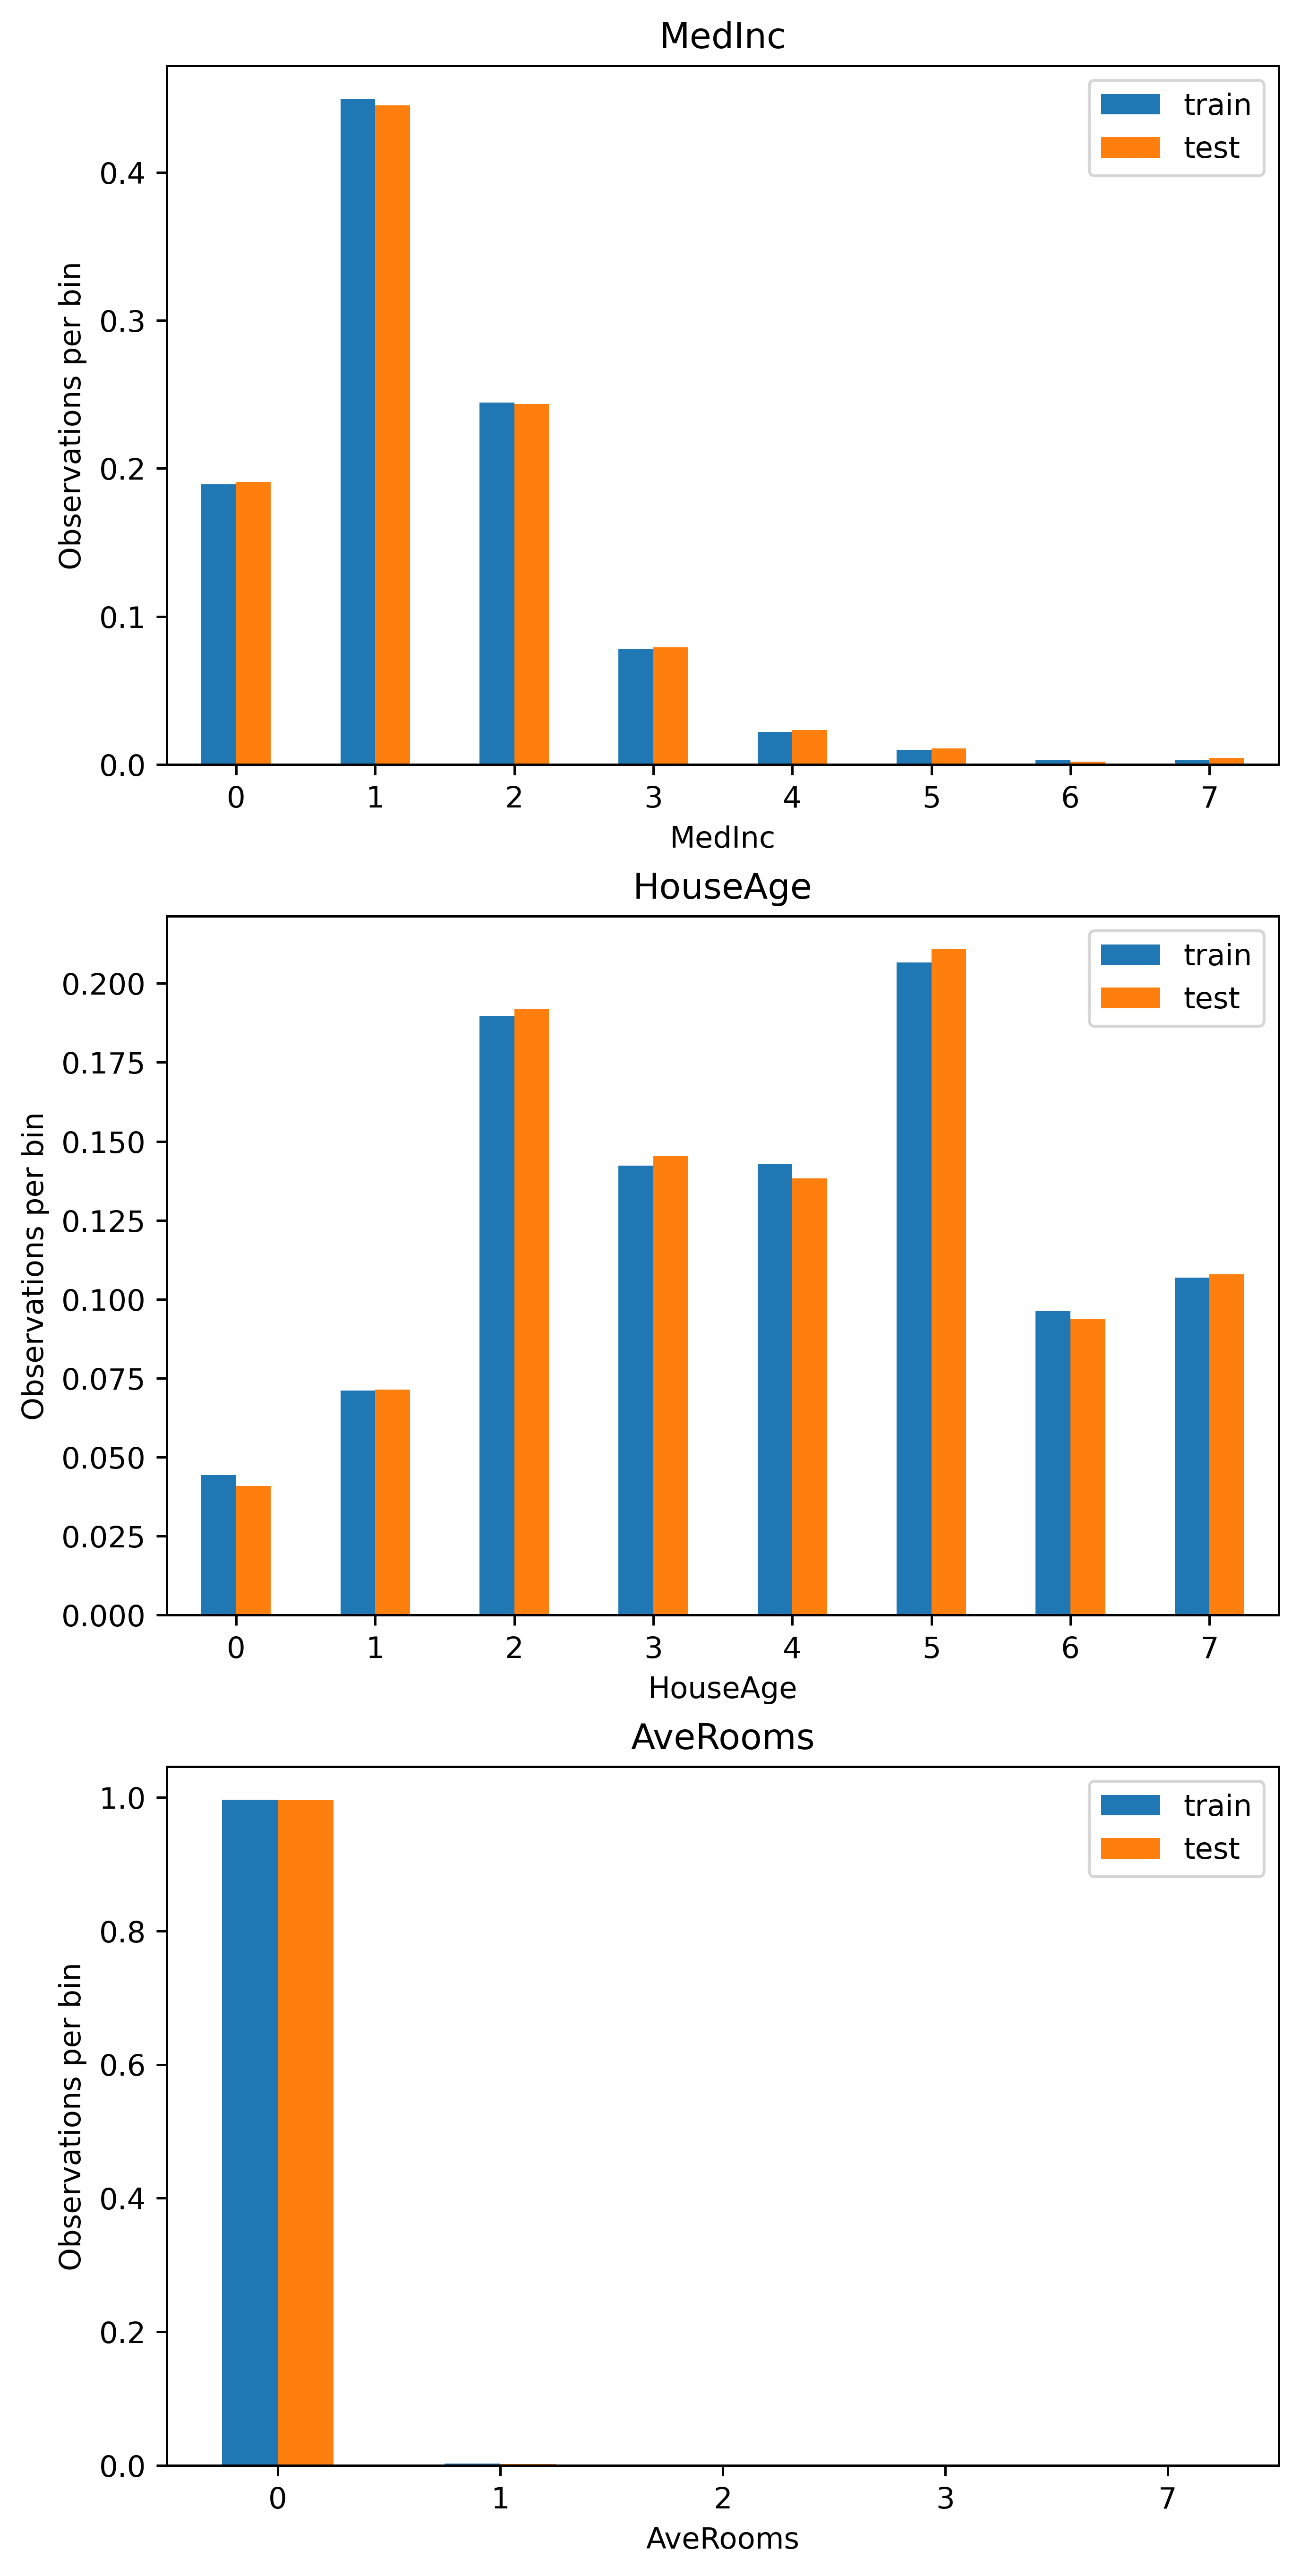

In [20]:
# Let's make bar plots with the number of
# observations per bin for the 3 discretized
# variables:

plt.figure(figsize=(6, 12), constrained_layout=True)

for i in range(3):

    # location of plot in figure
    ax = plt.subplot(3, 1, i + 1)

    # the variable to plot
    var = variables[i]

    # determine proportion of observations per bin
    t1 = train_t[var].value_counts(normalize=True, sort=False)
    t2 = test_t[var].value_counts(normalize=True, sort=False)

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ["train", "test"]

    # sort the intervals
    tmp.sort_index(inplace=True)

    # make plot
    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=0)
    plt.ylabel("Observations per bin")

    # add variable name as title
    ax.set_title(var)

plt.show()

## Equal-width discretization with Scikit-Learn

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer

In [22]:
# let's set up an equal-width discretizer into 8 intervals

disc = KBinsDiscretizer(
    n_bins=8, encode="ordinal",
    strategy="uniform", subsample=None)

# Let's set up the column transformer to apply the discretization
# to the selected variables

ct = ColumnTransformer(
    [("discretizer", disc, variables)],
    remainder="passthrough",
).set_output(transform="pandas")


# let's fit the discretizer so it learns the interval limits
ct.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('discretizer',
                                 KBinsDiscretizer(encode='ordinal', n_bins=8,
                                                  strategy='uniform',
                                                  subsample=None),
                                 ['MedInc', 'HouseAge', 'AveRooms'])])

In [23]:
# the interval limits are stored in the bin_edges_ attribute

ct.named_transformers_["discretizer"].bin_edges_

array([array([ 0.4999  ,  2.312425,  4.12495 ,  5.937475,  7.75    ,  9.562525,
              11.37505 , 13.187575, 15.0001  ])                                ,
       array([ 1.   ,  7.375, 13.75 , 20.125, 26.5  , 32.875, 39.25 , 45.625,
              52.   ])                                                       ,
       array([  0.84615385,  17.30705128,  33.76794872,  50.22884615,
               66.68974359,  83.15064103,  99.61153846, 116.0724359 ,
              132.53333333])                                         ],
      dtype=object)

In [24]:
# transform the data

train_t = ct.transform(X_train)
test_t = ct.transform(X_test)

train_t.head()

,discretizer__MedInc,discretizer__HouseAge,discretizer__AveRooms,remainder__AveBedrms,remainder__Population,remainder__AveOccup,remainder__Latitude,remainder__Longitude
1989,0.0,7.0,0.0,0.700000,193.0,4.825000,36.73,-119.79
256,0.0,6.0,0.0,1.184116,836.0,3.018051,37.77,-122.21
7887,3.0,2.0,0.0,1.087912,1387.0,3.810440,33.87,-118.04
4581,0.0,2.0,0.0,1.196000,3051.0,3.051000,34.06,-118.28
1993,0.0,7.0,0.0,1.161677,606.0,3.628743,36.73,-119.81


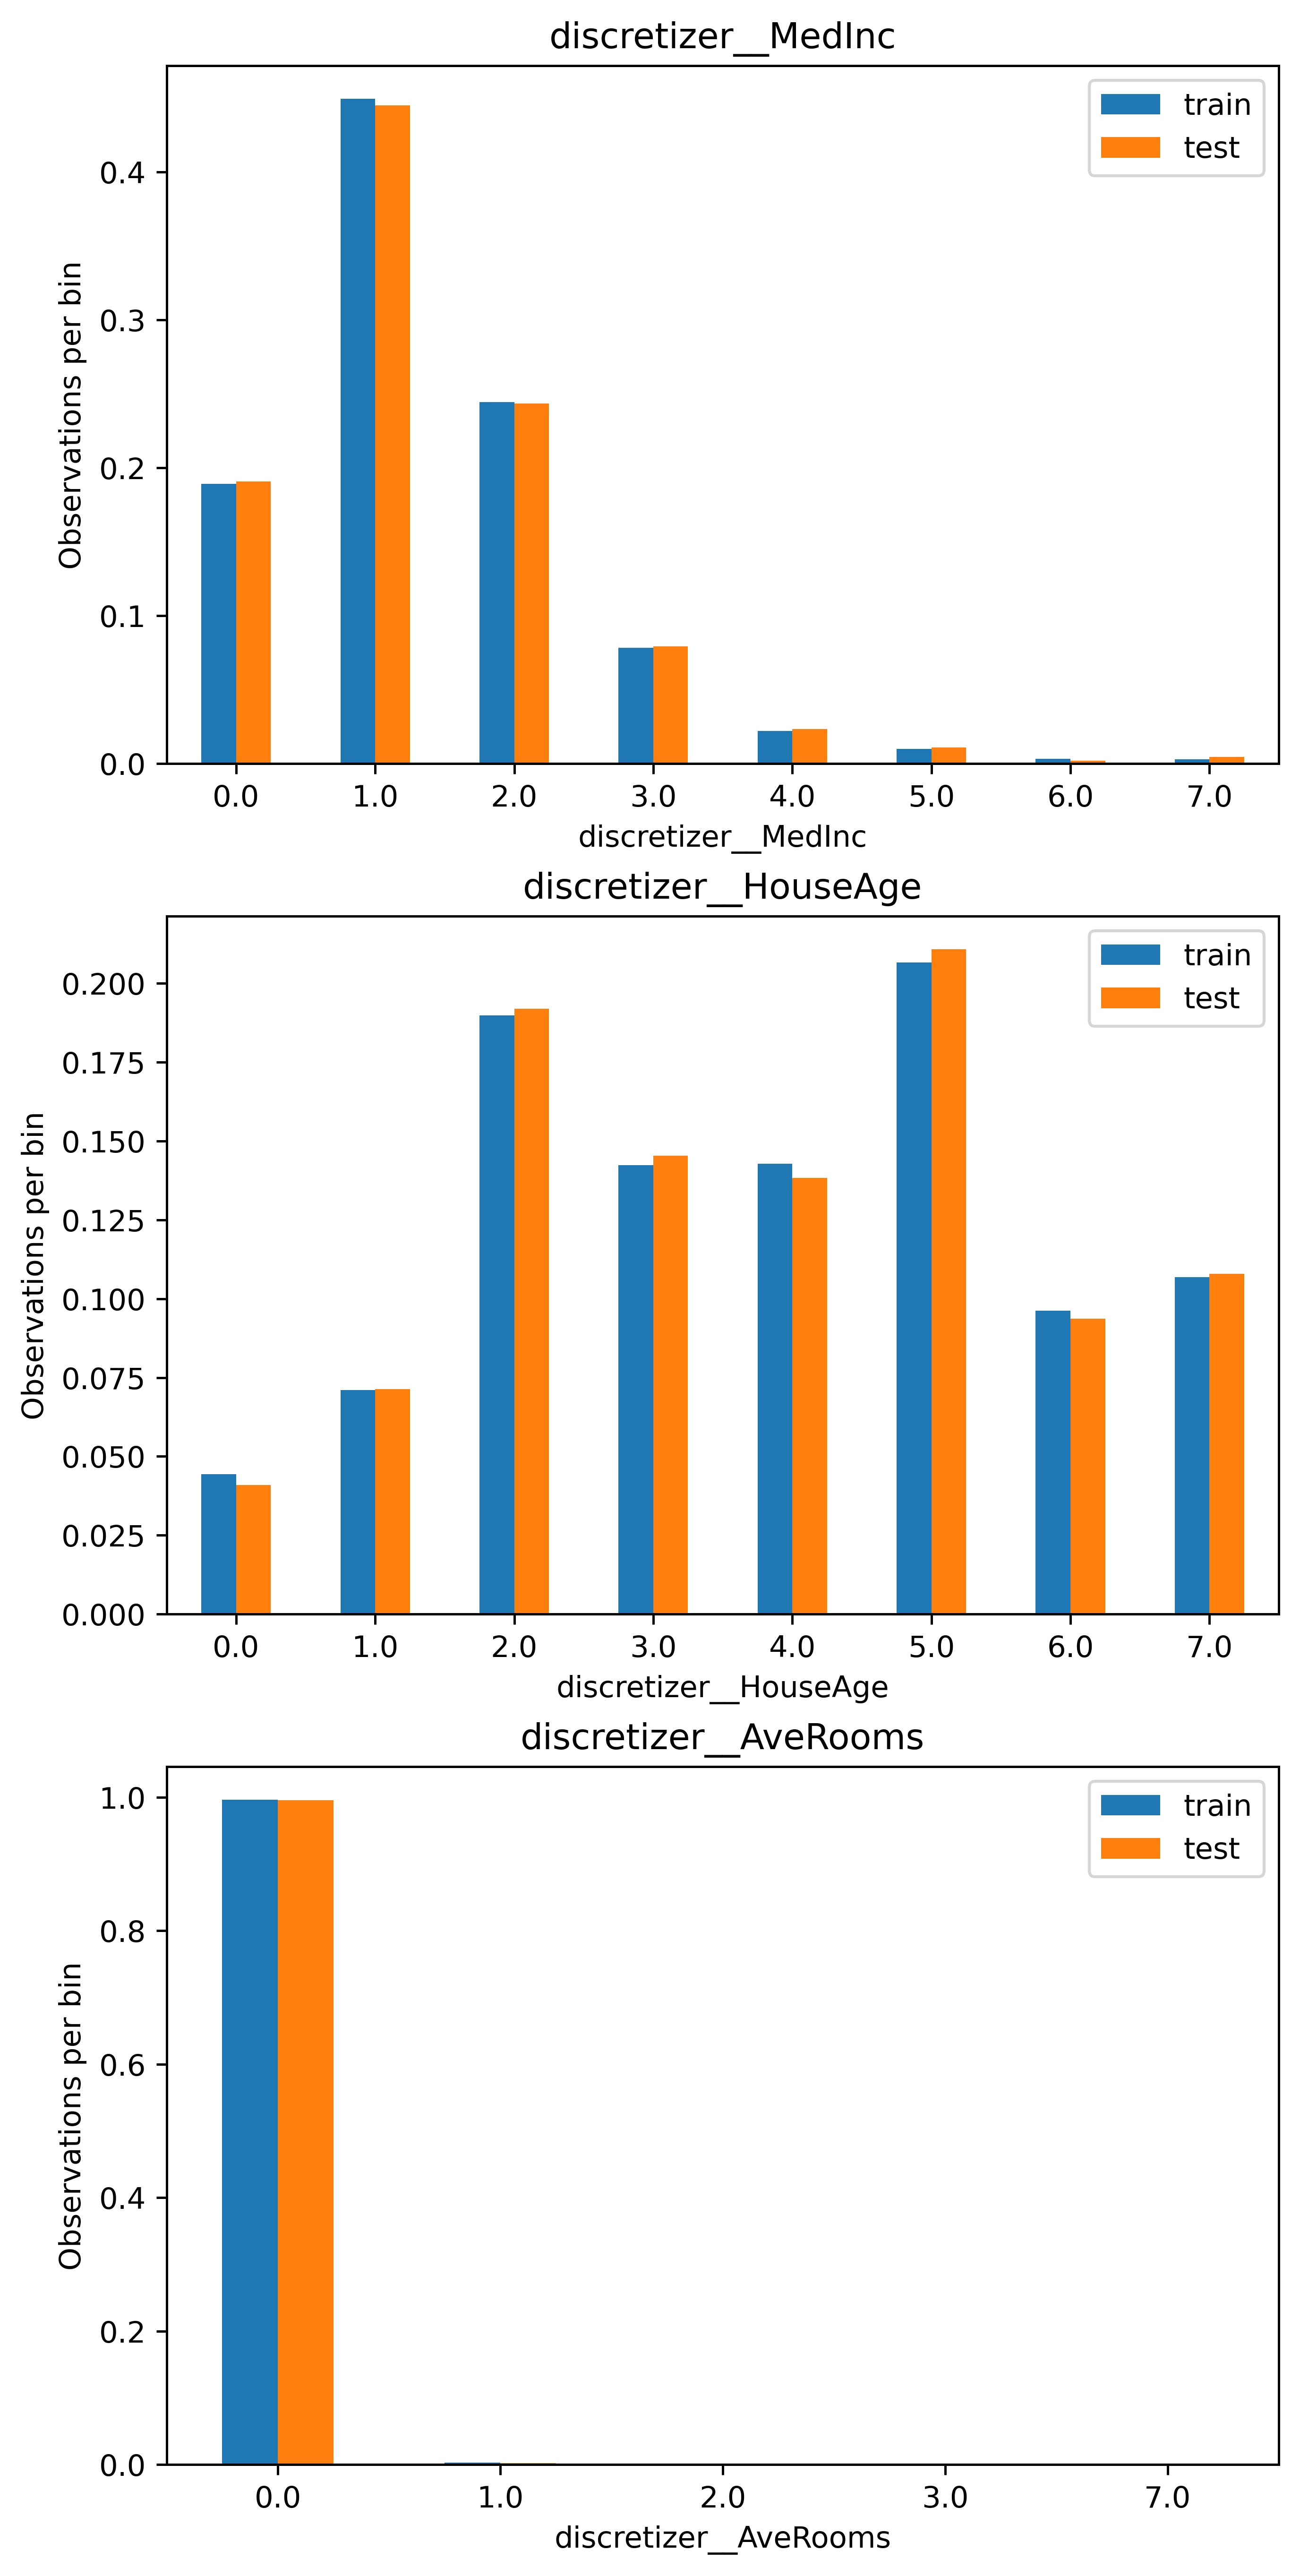

In [25]:
# Let's make bar plots with the number of
# observations per bin for the 3 discretized
# variables:

variables = ["discretizer__MedInc", "discretizer__HouseAge", "discretizer__AveRooms"]

plt.figure(figsize=(6, 12), constrained_layout=True)

for i in range(3):

    # location in figure
    ax = plt.subplot(3, 1, i + 1)

    # variable to plot
    var = variables[i]

    # determine proportion of observations per bin
    t1 = train_t[var].value_counts(normalize=True, sort=False).sort_index()
    t2 = test_t[var].value_counts(normalize=True, sort=False).sort_index()

    # concatenate proportions
    tmp = pd.concat([t1, t2], axis=1)
    tmp.columns = ["train", "test"]

    tmp.plot.bar(ax=ax)
    plt.xticks(rotation=0)
    plt.ylabel("Observations per bin")

    # add variable name as title
    ax.set_title(var)

plt.show()